# chips-net analysis

This analysis notebook contains the following sections

- Exploring the data: looking at the truth distributions and event image representations
- Simple cuts to remove background
- Which event image representation is best?
- Which training sample is best?
- Trying a multi-task model
- Explaining the cosmic and beam classifiers
- Can we determine the primary particles?
- Final combined classification analysis and comparison with legacy PID

In [1]:
# Input parameters for this notebook...
config_path = "/mnt/storage/jtingey/chips-net/config/analysis/eval.yaml"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

In [2]:
# Import the standard modules
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

# Setup Tensorflow and the GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

# chipsnet imports
import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
from chipsnet.utils import process_ds

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)

## Load data/models and run inference

In [4]:
config = chipsnet.config.get(config_path)
v_c_flux_ev, v_c_flux_out = process_ds(config, "v_c_flux", ["t_all_cat_v_c_uniform"])
v_ct_flux_ev, v_ct_flux_out = process_ds(config, "v_ct_flux", ["t_all_cat_v_ct_uniform"])
o_ct_flux_ev, o_ct_flux_out = process_ds(config, "o_ct_flux", ["t_all_cat_o_ct_uniform"])
i_ct_flux_ev, i_ct_flux_out = process_ds(config, "i_ct_flux", ["t_all_cat_i_ct_uniform"])

v_cth_flux_ev, v_cth_flux_out = process_ds(config,"v_cth_flux", ["t_all_cat_v_cth_uniform", "t_all_cat_v_cth_flux", "multi_v_cth_flux", "multi_v_cth_uniform", "multi_energy_v_cth_uniform", "t_cos_cat_v_cth_uniform"])
v_cth_uniform_ev, v_cth_uniform_out = process_ds(config, "v_cth_uniform", ["t_all_cat_v_cth_uniform", "multi_v_cth_uniform"])

v_cth_flux_cos_ev, v_cth_flux_cos_out = process_ds(config, "v_cth_flux_cos", ["t_cos_cat_v_cth_flux", "t_cos_cat_v_cth_uniform"])
v_cth_uniform_cos_ev, v_cth_uniform_cos_out = process_ds(config, "v_cth_uniform_cos", ["t_cos_cat_v_cth_uniform"])

Processing v_c_flux... took 44.65 seconds
Processing v_ct_flux... took 40.89 seconds
Processing o_ct_flux... took 39.64 seconds
Processing i_ct_flux... 

/mnt/storage/jtingey/chips-net/chipsnet/utils.py:571: RuntimeWarning: invalid value encountered in true_divide
  fom_purs.append(np.divide(signal_h, np.add(signal_h, bkg_h)))


took 39.95 seconds
Processing v_cth_flux... took 203.68 seconds
Processing v_cth_uniform... took 75.57 seconds
Processing v_cth_flux_cos... took 29.26 seconds
Processing v_cth_uniform_cos... took 18.28 seconds


## Exploring the data

First let's explore the input data we have to work with...

Figuring out how best to represent the 2D surface of a cylindrical detector for a 2d convolutional network is a challenge.
The simplest approach would be to ignore the endcaps and just use a square/rectangular map of the detector barrel as input.
However, a large fraction of the Cherenkov light collected by the detector hits the endcaps so we will be loosing a lot of infomation...

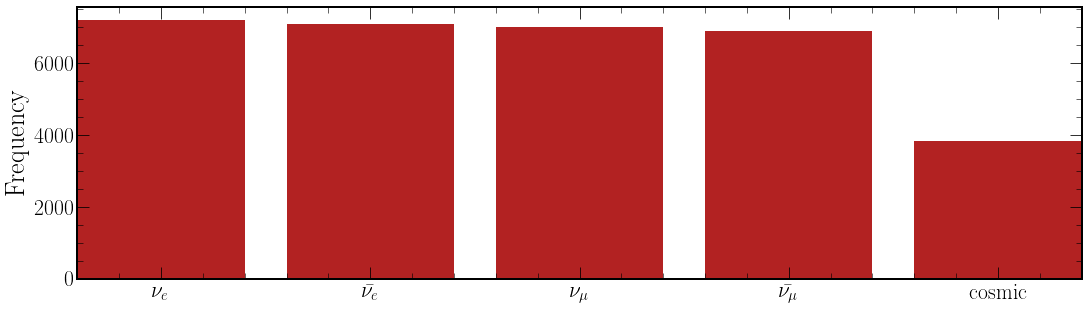

<Figure size 720x720 with 0 Axes>

In [5]:
# change variable name for dataframes to make everything easier
events_u = v_cth_uniform_cos_ev  
events_b = v_cth_flux_cos_ev

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[events_b.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic'))
axs.set_ylabel("Frequency")
plt.show()
plt.savefig('./data/output/nu_types.pgf')
plt.savefig('./data/output/nu_types.png')

In [33]:
def plot_cats(events_u, events_b, map):
    data_u = [len(events_u[events_u[map.name] == i]) for i in range(len(map.labels))]
    data_b = [len(events_b[events_b[map.name] == i]) for i in range(len(map.labels))]
    cats = np.arange(len(map.labels))
    width = 0.4

    fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
    axs.bar(cats+width/2, data_u, color="royalblue", width=width)
    axs.bar(cats-width/2, data_b, color="firebrick", width=width)
    axs.set_xticks(cats)
    axs.set_xticklabels(map.labels, fontsize=14, rotation='vertical')
    axs.set_ylabel("Frequency")
    plt.show()
    plt.savefig('./data/output/' + map.name + '_.pgf')
    plt.savefig('./data/output/' + map.name + '_.png')

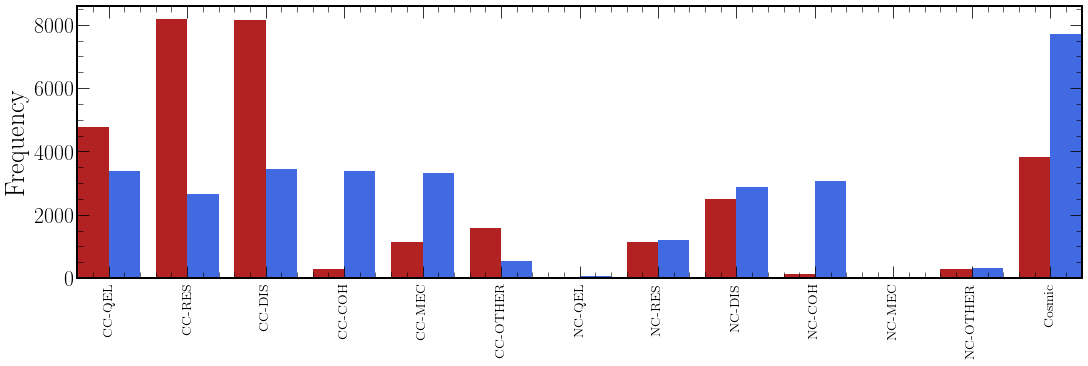

<Figure size 720x720 with 0 Axes>

In [34]:
plot_cats(events_u, events_b, chipsnet.data.MAP_INT_TYPE)

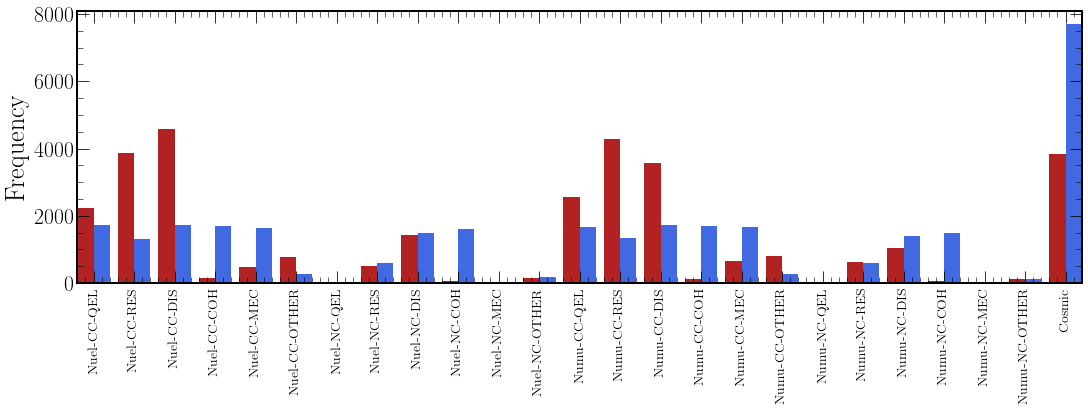

<Figure size 720x720 with 0 Axes>

In [35]:
plot_cats(events_u, events_b, chipsnet.data.MAP_ALL_CAT)

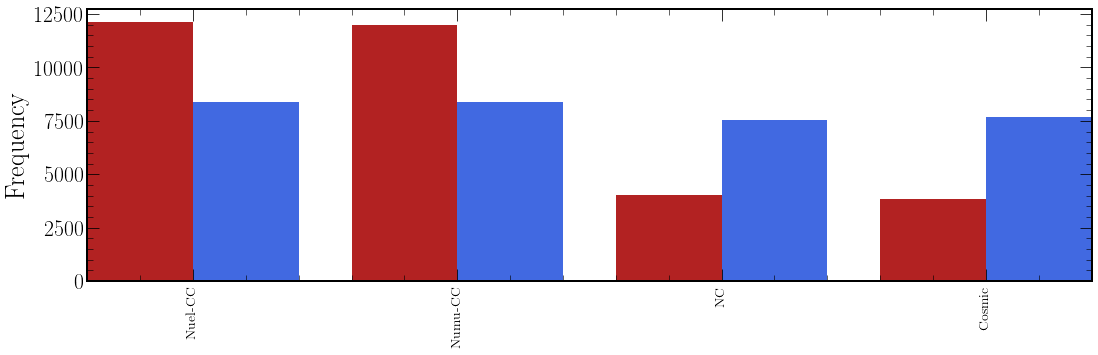

<Figure size 720x720 with 0 Axes>

In [36]:
plot_cats(events_u, events_b, chipsnet.data.MAP_FULL_COMB_CAT)

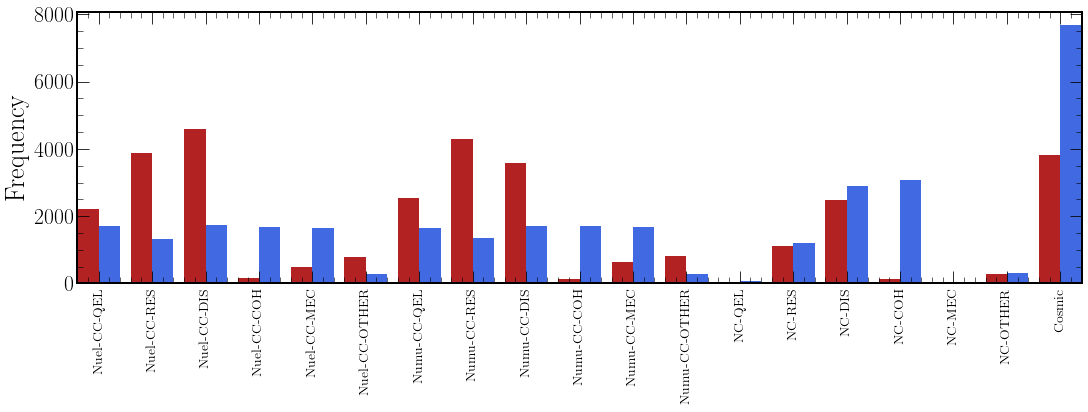

<Figure size 720x720 with 0 Axes>

In [37]:
plot_cats(events_u, events_b, chipsnet.data.MAP_NU_NC_COMB_CAT)

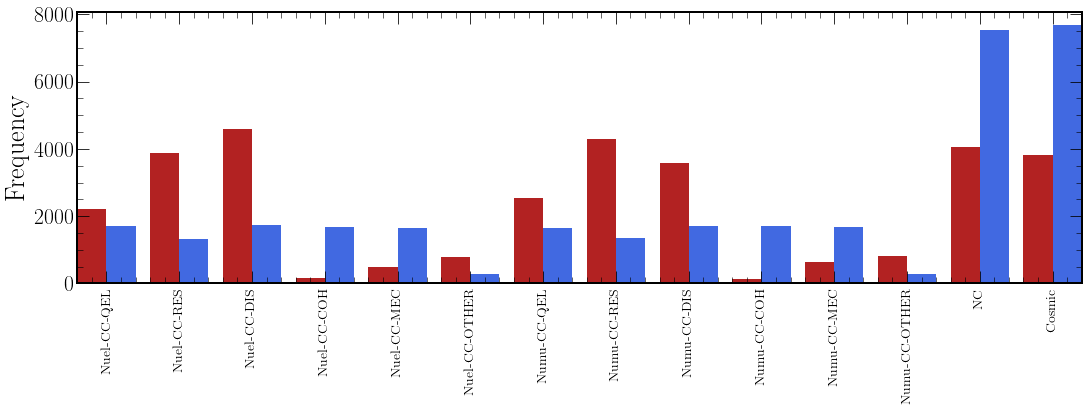

<Figure size 720x720 with 0 Axes>

In [38]:
plot_cats(events_u, events_b, chipsnet.data.MAP_NC_COMB_CAT)

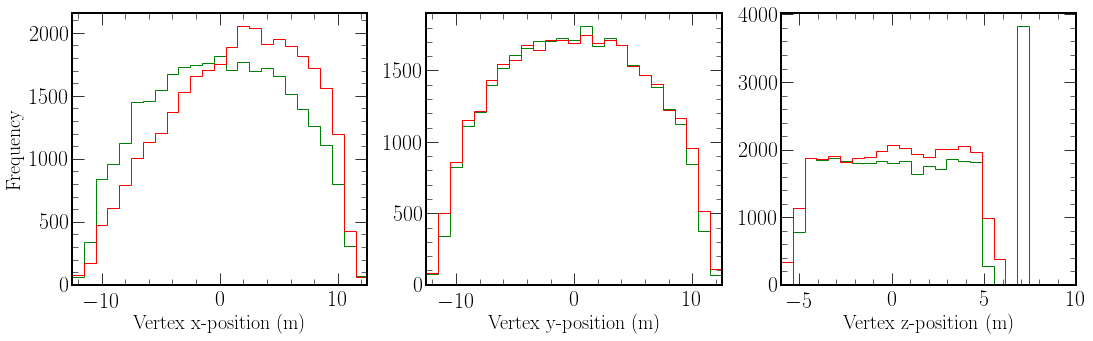

<Figure size 720x720 with 0 Axes>

In [20]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[0].hist(events_b["r_vtxX"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[1].hist(events_b["r_vtxY"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100, range=(-6, 10), bins=25, color='green', histtype='step')
axs[2].hist(events_b["r_vtxZ"]*600/100, range=(-6, 10), bins=25, color='red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
plt.show()
plt.savefig('./data/output/vtx_position.pgf')
plt.savefig('./data/output/vtx_position.png')

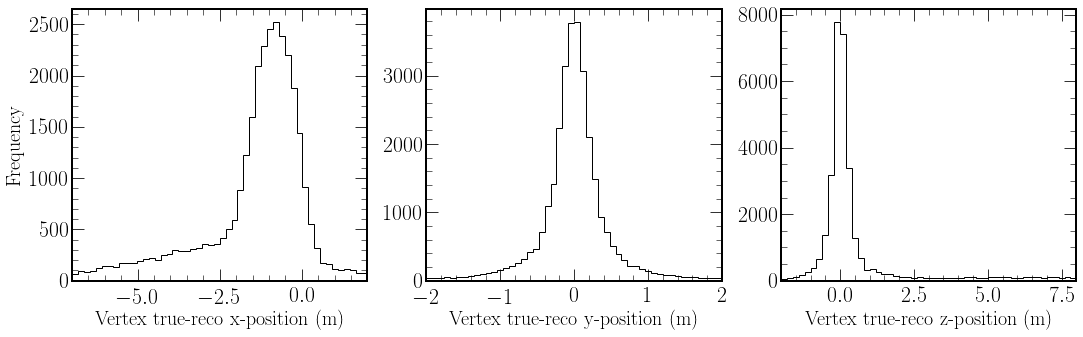

<Figure size 720x720 with 0 Axes>

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100-(events_b["r_vtxX"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100-(events_b["r_vtxY"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100-(events_b["r_vtxZ"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
plt.show()
plt.savefig('./data/output/true_reco_vtx.pgf')
plt.savefig('./data/output/true_reco_vtx.png')

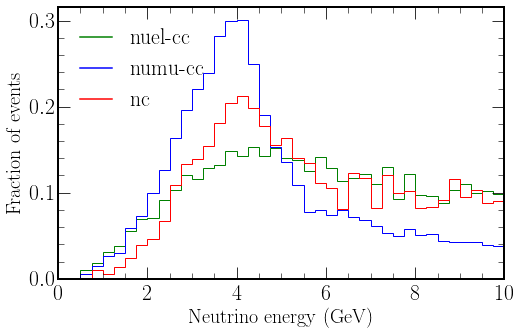

In [32]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_b = matplotlib.lines.Line2D([], [], c='blue')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(events_b[events_b["t_comb_cat"] == 0]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='green', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 1]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='blue', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 2]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["nuel-cc", "numu-cc", "nc"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
plt.show()

In [39]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_raw_charge_map_origin": [], "r_raw_charge_map_iso": [], "r_raw_charge_map_vtx": [],
               "r_raw_time_map_origin": [], "r_raw_time_map_iso": [], "r_raw_time_map_vtx": [], "r_raw_hit_hough_map_vtx": []}
channel_hists = images_dict

In [40]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.47705780747902665


In [41]:
def plot_hit_time(images_dict, event):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs[0, 0].imshow(images_dict['r_raw_charge_map_origin'][event], cmap='Reds', origin='lower')
    axs[0, 0].set_title('$\phi$ and $\\theta$ from origin')
    axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[0, 1].imshow(images_dict['r_raw_charge_map_iso'][event], cmap='Reds', origin='lower')
    axs[0, 1].set_title('$x^{+}$ and $x^{-}$ from origin')
    axs[0, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[0, 2].imshow(images_dict['r_raw_charge_map_vtx'][event], cmap='Reds', origin='lower')
    axs[0, 2].set_title('$\phi$ and $\\theta$ from vertex')
    axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[0, 2].text(68, 3, 'Desposited charge images', rotation=-90, fontsize=18)

    axs[1, 0].imshow(images_dict['r_raw_time_map_origin'][event], cmap='Reds', origin='lower')
    axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[1, 1].imshow(images_dict['r_raw_time_map_iso'][event], cmap='Reds', origin='lower')
    axs[1, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[1, 2].imshow(images_dict['r_raw_time_map_vtx'][event], cmap='Reds', origin='lower')
    axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[1, 2].text(68, 10, 'First hit time images', rotation=-90, fontsize=18)
    
def plot_hough(images_dict, event):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs.imshow(images_dict['r_raw_hit_hough_map_vtx'][event], cmap='Reds', origin='lower')
    axs.set_title('$\phi$ and $\\theta$ from vertex')
    axs.set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs.text(68, 13, 'Hough space image', rotation=-90, fontsize=18)

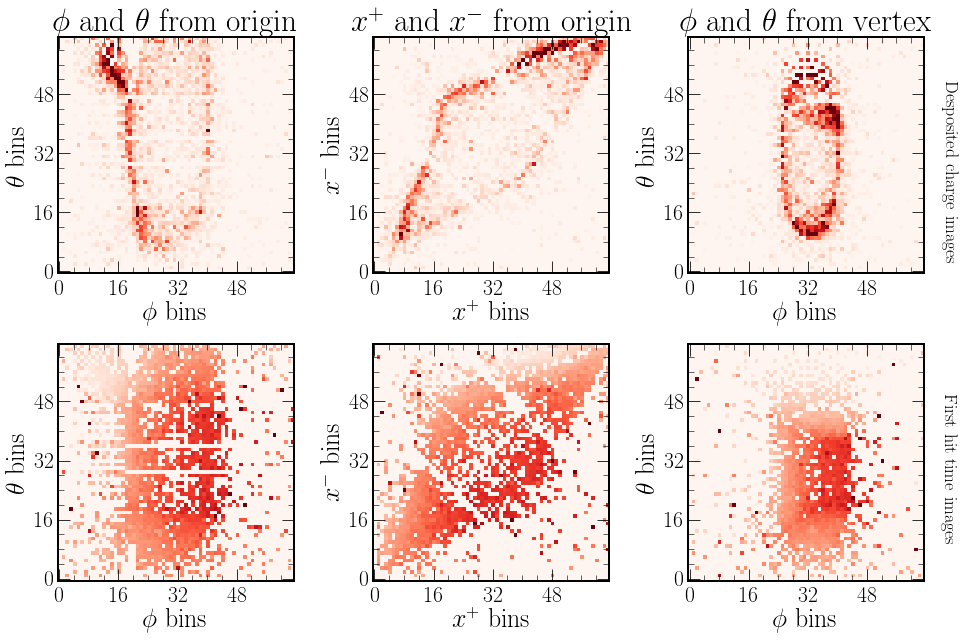

In [42]:
plot_hit_time(images_dict, 1)

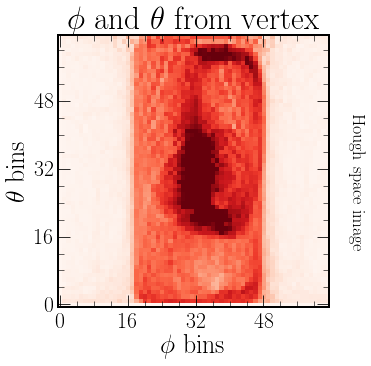

In [43]:
plot_hough(images_dict, 1)

In [44]:
def plot_8bit_range(images_dict, max_charge=30, max_time=130, max_hough=4000):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    #plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    
    hist_data = []
    for event in images_dict['r_raw_charge_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[0].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[0].set_title("[0,{}], outside range: {:.4f}".format(max_charge, occurrences), fontsize=17)
    axs[0].set(xlabel='Hit charge 8-bit value', ylabel='Frequency')
    axs[0].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_time_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[1].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[1].set_title("[0,{}], outside range: {:.4f}".format(max_time, occurrences), fontsize=17)
    axs[1].set(xlabel='Hit time 8-bit value', ylabel='Frequency')
    axs[1].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_hit_hough_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[2].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[2].set_title("[0,{}], outside range: {:.4f}".format(max_hough, occurrences), fontsize=17)
    axs[2].set(xlabel='Hough 8-bit value', ylabel='Frequency')
    axs[2].label_outer()

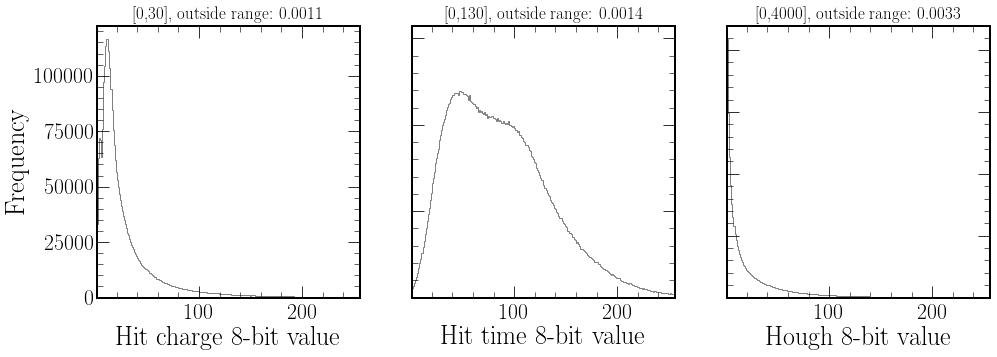

In [45]:
plot_8bit_range(images_dict)

## Simple cuts to remove background

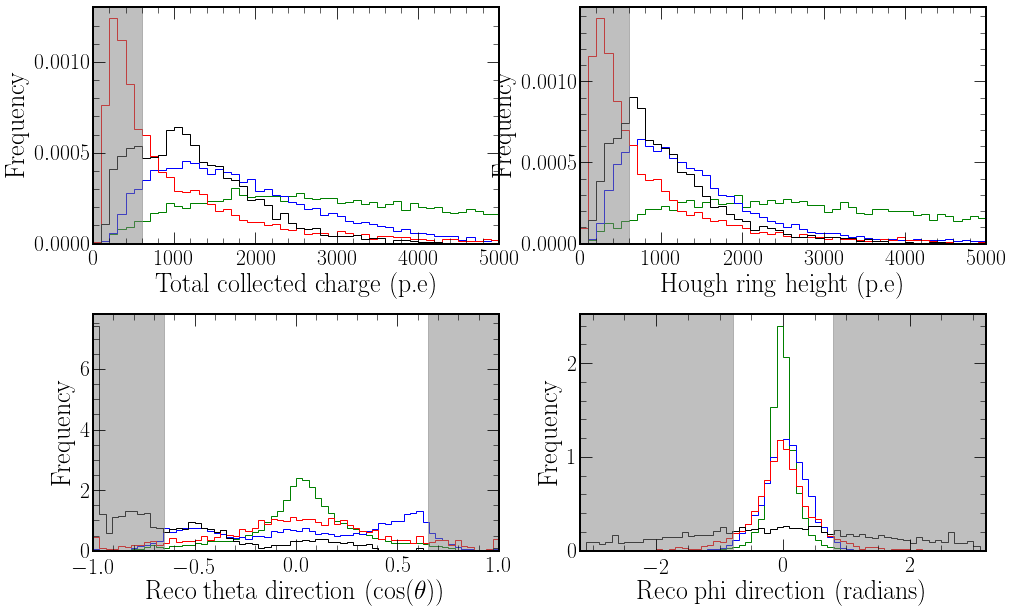

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(events_b[events_b.t_comb_cat == 0]['r_raw_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 1]['r_raw_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 2]['r_raw_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 3]['r_raw_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, 600, alpha=0.5, color='grey')

axs[0, 1].hist(events_b[events_b.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, 600, alpha=0.5, color='grey')

axs[1, 0].hist(events_b[events_b.t_comb_cat == 0]['r_dirTheta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 1]['r_dirTheta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 2]['r_dirTheta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 3]['r_dirTheta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -0.65, alpha=0.5, color='grey')
axs[1, 0].axvspan(0.65, 1, alpha=0.5, color='grey')

axs[1, 1].hist(events_b[events_b.t_comb_cat == 0]['r_dirPhi']*3.14159, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 1]['r_dirPhi']*3.14159, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 2]['r_dirPhi']*3.14159, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 3]['r_dirPhi']*3.14159, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -0.79, alpha=0.5, color='grey')
axs[1, 1].axvspan(0.79, 3.2, alpha=0.5, color='grey')
plt.show()

## Comparing the different image types

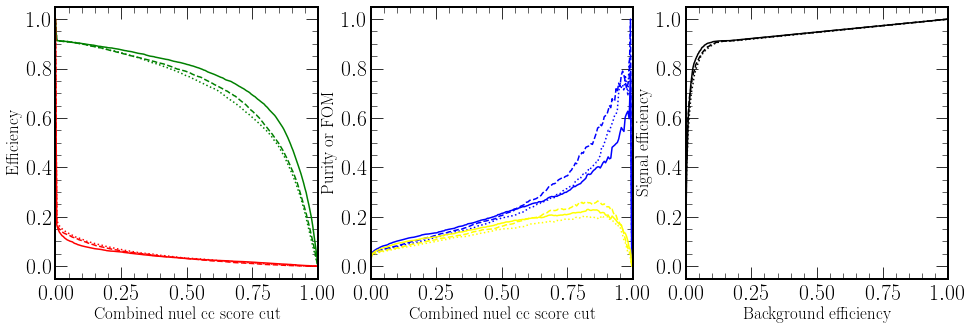

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(v_ct_flux_out["cuts"][0], v_ct_flux_out["sig_effs"][0][0], color='green')
axs[0].plot(o_ct_flux_out["cuts"][0], o_ct_flux_out["sig_effs"][0][0], color='green', linestyle='dashed')
axs[0].plot(i_ct_flux_out["cuts"][0], i_ct_flux_out["sig_effs"][0][0], color='green', linestyle='dotted')
axs[0].plot(v_ct_flux_out["cuts"][0], v_ct_flux_out["bkg_effs"][0][0], color='red')
axs[0].plot(o_ct_flux_out["cuts"][0], o_ct_flux_out["bkg_effs"][0][0], color='red', linestyle='dashed')
axs[0].plot(i_ct_flux_out["cuts"][0], i_ct_flux_out["bkg_effs"][0][0], color='red', linestyle='dotted')
axs[0].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)

axs[1].plot(v_ct_flux_out["cuts"][0], v_ct_flux_out["purs"][0][0], color='blue')
axs[1].plot(o_ct_flux_out["cuts"][0], o_ct_flux_out["purs"][0][0], color='blue', linestyle='dashed')
axs[1].plot(i_ct_flux_out["cuts"][0], i_ct_flux_out["purs"][0][0], color='blue', linestyle='dotted')
axs[1].plot(v_ct_flux_out["cuts"][0], v_ct_flux_out["foms"][0][0], color='yellow')
axs[1].plot(o_ct_flux_out["cuts"][0], o_ct_flux_out["foms"][0][0], color='yellow', linestyle='dashed')
axs[1].plot(i_ct_flux_out["cuts"][0], i_ct_flux_out["foms"][0][0], color='yellow', linestyle='dotted')
axs[1].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[1].set_ylabel('Purity or FOM', fontsize=17)

axs[2].plot(v_ct_flux_out["bkg_effs"][0][0], v_ct_flux_out["sig_effs"][0][0], color='black')
axs[2].plot(o_ct_flux_out["bkg_effs"][0][0], o_ct_flux_out["sig_effs"][0][0], color='black', linestyle='dashed')
axs[2].plot(i_ct_flux_out["bkg_effs"][0][0], i_ct_flux_out["sig_effs"][0][0], color='black', linestyle='dotted')
axs[2].set_xlabel('Background efficiency', fontsize=17)
axs[2].set_ylabel('Signal efficiency', fontsize=17)
plt.show()

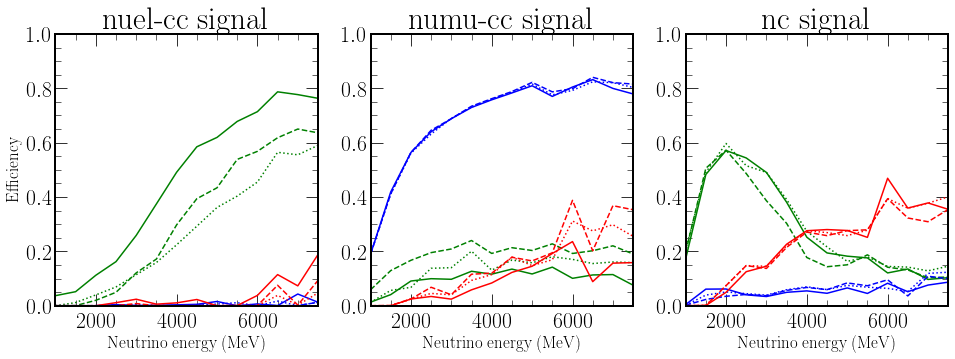

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][0], color='green')
axs[0].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][0][0], color='green', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][0][0], color='green', linestyle='dotted')
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][1], color='blue')
axs[0].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][0][1], color='blue', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][0][1], color='blue', linestyle='dotted')
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][2], color='red')
axs[0].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][0][2], color='red', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][0][2], color='red', linestyle='dotted')
axs[0].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)
axs[0].set_ylim([0, 1])
axs[0].set_title('nuel-cc signal')

axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][0], color='green')
axs[1].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][1][0], color='green', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][1][0], color='green', linestyle='dotted')
axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][1], color='blue')
axs[1].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][1][1], color='blue', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][1][1], color='blue', linestyle='dotted')
axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][2], color='red')
axs[1].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][1][2], color='red', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][1][2], color='red', linestyle='dotted')
axs[1].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[1].set_ylim([0, 1])
axs[1].set_title('numu-cc signal')

axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][0], color='green')
axs[2].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][2][0], color='green', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][2][0], color='green', linestyle='dotted')
axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][1], color='blue')
axs[2].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][2][1], color='blue', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][2][1], color='blue', linestyle='dotted')
axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][2], color='red')
axs[2].plot(np.arange(1000, 8000, 500), o_ct_flux_out["fom_effs"][0][2][2], color='red', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), i_ct_flux_out["fom_effs"][0][2][2], color='red', linestyle='dotted')
axs[2].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[2].set_ylim([0, 1])
axs[2].set_title('nc signal')
plt.show()

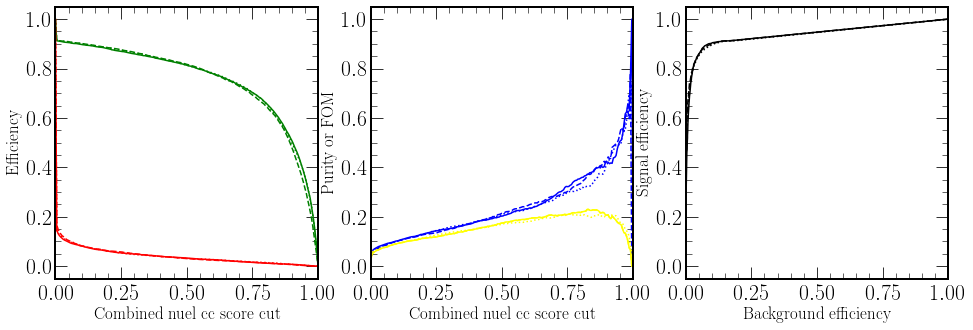

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(v_ct_flux_out["cuts"][0], v_c_flux_out["sig_effs"][0][0], color='green')
axs[0].plot(o_ct_flux_out["cuts"][0], v_ct_flux_out["sig_effs"][0][0], color='green', linestyle='dashed')
axs[0].plot(i_ct_flux_out["cuts"][0], v_cth_flux_out["sig_effs"][0][0], color='green', linestyle='dotted')
axs[0].plot(v_ct_flux_out["cuts"][0], v_c_flux_out["bkg_effs"][0][0], color='red')
axs[0].plot(o_ct_flux_out["cuts"][0], v_ct_flux_out["bkg_effs"][0][0], color='red', linestyle='dashed')
axs[0].plot(i_ct_flux_out["cuts"][0], v_cth_flux_out["bkg_effs"][0][0], color='red', linestyle='dotted')
axs[0].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)

axs[1].plot(v_ct_flux_out["cuts"][0], v_c_flux_out["purs"][0][0], color='blue')
axs[1].plot(o_ct_flux_out["cuts"][0], v_ct_flux_out["purs"][0][0], color='blue', linestyle='dashed')
axs[1].plot(i_ct_flux_out["cuts"][0], v_cth_flux_out["purs"][0][0], color='blue', linestyle='dotted')
axs[1].plot(v_ct_flux_out["cuts"][0], v_ct_flux_out["foms"][0][0], color='yellow')
axs[1].plot(o_ct_flux_out["cuts"][0], v_ct_flux_out["foms"][0][0], color='yellow', linestyle='dashed')
axs[1].plot(i_ct_flux_out["cuts"][0], v_cth_flux_out["foms"][0][0], color='yellow', linestyle='dotted')
axs[1].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[1].set_ylabel('Purity or FOM', fontsize=17)

axs[2].plot(v_ct_flux_out["bkg_effs"][0][0], v_c_flux_out["sig_effs"][0][0], color='black')
axs[2].plot(o_ct_flux_out["bkg_effs"][0][0], v_ct_flux_out["sig_effs"][0][0], color='black', linestyle='dashed')
axs[2].plot(i_ct_flux_out["bkg_effs"][0][0], v_cth_flux_out["sig_effs"][0][0], color='black', linestyle='dotted')
axs[2].set_xlabel('Background efficiency', fontsize=17)
axs[2].set_ylabel('Signal efficiency', fontsize=17)
plt.show()

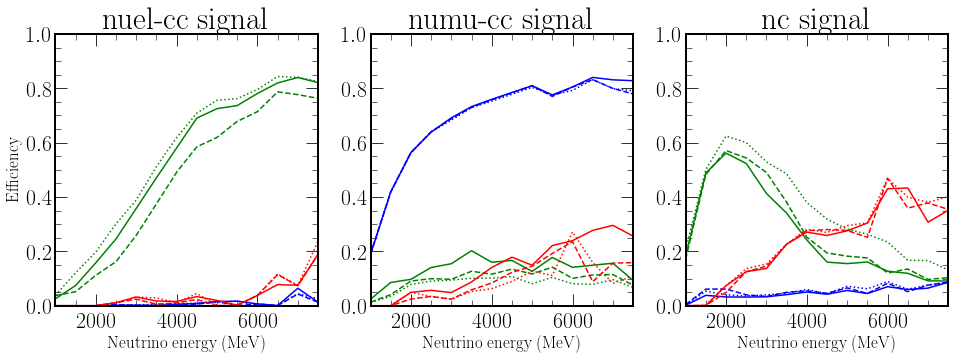

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][0][0], color='green')
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][0], color='green', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][0], color='green', linestyle='dotted')
axs[0].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][0][1], color='blue')
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][1], color='blue', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][1], color='blue', linestyle='dotted')
axs[0].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][0][2], color='red')
axs[0].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][0][2], color='red', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][2], color='red', linestyle='dotted')
axs[0].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)
axs[0].set_ylim([0, 1])
axs[0].set_title('nuel-cc signal')

axs[1].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][1][0], color='green')
axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][0], color='green', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][0], color='green', linestyle='dotted')
axs[1].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][1][1], color='blue')
axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][1], color='blue', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][1], color='blue', linestyle='dotted')
axs[1].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][1][2], color='red')
axs[1].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][1][2], color='red', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][2], color='red', linestyle='dotted')
axs[1].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[1].set_ylim([0, 1])
axs[1].set_title('numu-cc signal')

axs[2].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][2][0], color='green')
axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][0], color='green', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][0], color='green', linestyle='dotted')
axs[2].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][2][1], color='blue')
axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][1], color='blue', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][1], color='blue', linestyle='dotted')
axs[2].plot(np.arange(1000, 8000, 500), v_c_flux_out["fom_effs"][0][2][2], color='red')
axs[2].plot(np.arange(1000, 8000, 500), v_ct_flux_out["fom_effs"][0][2][2], color='red', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][2], color='red', linestyle='dotted')
axs[2].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[2].set_ylim([0, 1])
axs[2].set_title('nc signal')
plt.show()

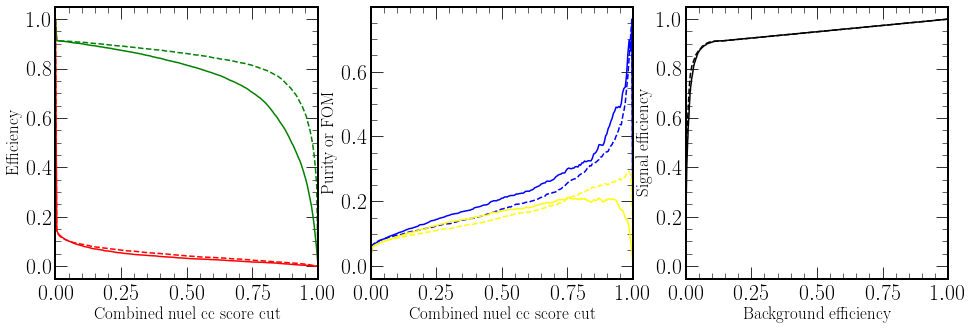

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["sig_effs"][0][0], color='green')
axs[0].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["sig_effs"][1][0], color='green', linestyle='dashed')
axs[0].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["bkg_effs"][0][0], color='red')
axs[0].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["bkg_effs"][1][0], color='red', linestyle='dashed')
axs[0].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)

axs[1].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["purs"][0][0], color='blue')
axs[1].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["purs"][1][0], color='blue', linestyle='dashed')
axs[1].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["foms"][0][0], color='yellow')
axs[1].plot(v_cth_flux_out["cuts"][0], v_cth_flux_out["foms"][1][0], color='yellow', linestyle='dashed')
axs[1].set_xlabel('Combined nuel cc score cut', fontsize=17)
axs[1].set_ylabel('Purity or FOM', fontsize=17)

axs[2].plot(v_cth_flux_out["bkg_effs"][0][0], v_cth_flux_out["sig_effs"][0][0], color='black')
axs[2].plot(v_cth_flux_out["bkg_effs"][1][0], v_cth_flux_out["sig_effs"][1][0], color='black', linestyle='dashed')
axs[2].set_xlabel('Background efficiency', fontsize=17)
axs[2].set_ylabel('Signal efficiency', fontsize=17)
plt.show()

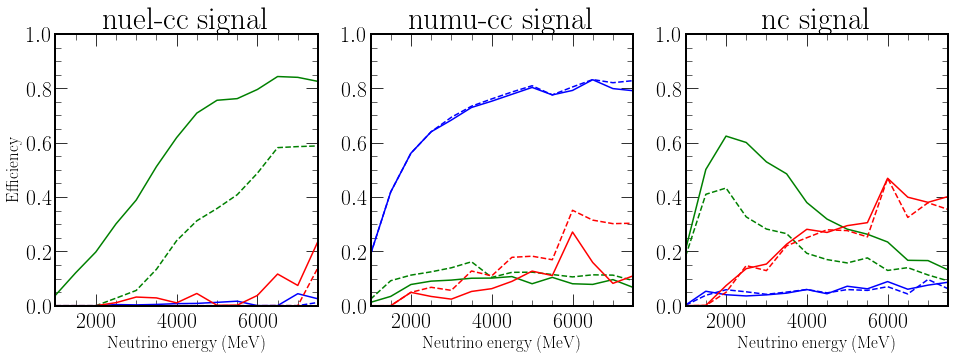

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][0], color='green')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][0][0], color='green', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][1], color='blue')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][0][1], color='blue', linestyle='dashed')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][0][2], color='red')
axs[0].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][0][2], color='red', linestyle='dashed')
axs[0].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[0].set_ylabel('Efficiency', fontsize=17)
axs[0].set_ylim([0, 1])
axs[0].set_title('nuel-cc signal')

axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][0], color='green')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][1][0], color='green', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][1], color='blue')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][1][1], color='blue', linestyle='dashed')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][1][2], color='red')
axs[1].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][1][2], color='red', linestyle='dashed')
axs[1].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[1].set_ylim([0, 1])
axs[1].set_title('numu-cc signal')

axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][0], color='green')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][2][0], color='green', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][1], color='blue')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][2][1], color='blue', linestyle='dashed')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][0][2][2], color='red')
axs[2].plot(np.arange(1000, 8000, 500), v_cth_flux_out["fom_effs"][1][2][2], color='red', linestyle='dashed')
axs[2].set_xlabel('Neutrino energy (MeV)', fontsize=17)
axs[2].set_ylim([0, 1])
axs[2].set_title('nc signal')
plt.show()

In [102]:
def plot_combined_values(events, prefix):
    bins = 25
    range=(0, 1)
    cat0 = prefix + "pred_t_comb_cat_0"
    cat1 = prefix + "pred_t_comb_cat_1"
    cat2 = prefix + "pred_t_comb_cat_2"
    nuel_cc_events = events[events["t_comb_cat"] == 0]
    numu_cc_events = events[events["t_comb_cat"] == 1]
    nc_events = events[events["t_comb_cat"] == 2]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
    axs[0].hist(nuel_cc_events[cat0], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[0].hist(numu_cc_events[cat0], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[0].hist(nc_events[cat0], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_yscale('log')
    
    axs[1].hist(nuel_cc_events[cat1], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[1].hist(numu_cc_events[cat1], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[1].hist(nc_events[cat1], weights=nc_events["w"], range=(0, 1), bins=bins, color='red', histtype='step')
    axs[1].set_xlabel('Combined numu cc score', fontsize=17)
    axs[1].set_yscale('log')
    
    axs[2].hist(nuel_cc_events[cat2], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[2].hist(numu_cc_events[cat2], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[2].hist(nc_events[cat2], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[2].set_xlabel('Combined nc score', fontsize=17)
    axs[2].set_yscale('log')
    plt.show()

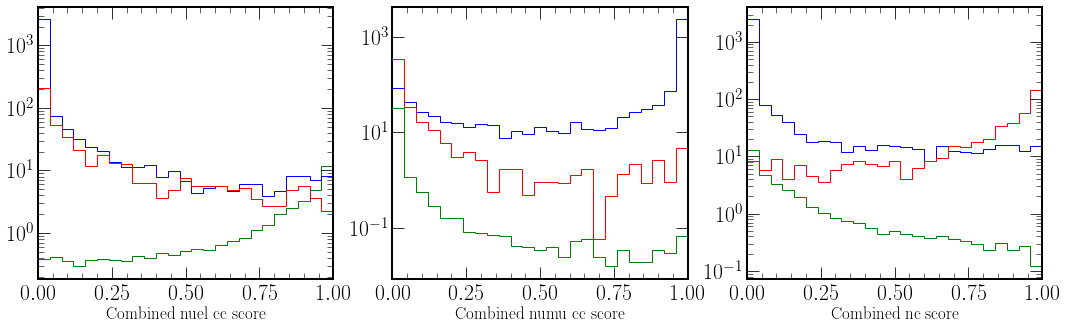

In [113]:
plot_combined_values(v_cth_flux_ev, prefix="t_all_cat_v_cth_uniform_")

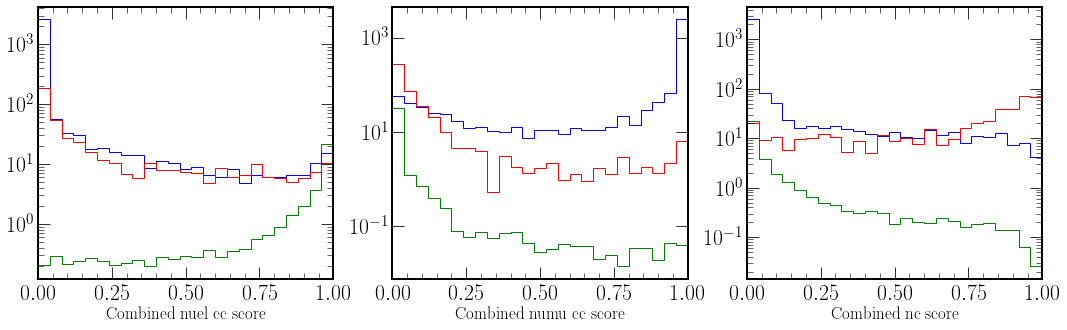

In [114]:
plot_combined_values(v_cth_flux_ev, prefix="t_all_cat_v_cth_flux_")

## Explainability

[Text(0, 0.5, '$\\theta$ bins'),
 Text(0.5, 0, '$\\phi$ bins'),
 Text(0.5, 1.0, 'GradCam Block 3')]

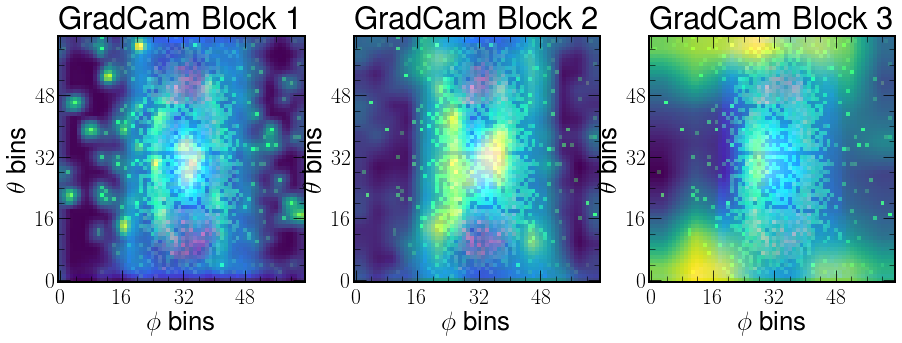

In [33]:
event = 11
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
#axs[1, 0].imshow(smooth_grads[event], cmap='Reds', origin='lower')
#axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Smooth gradients')
#axs[1, 1].imshow(int_grads[event], cmap='Reds', origin='lower')
#axs[1, 1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Int gradients')
#axs[1, 2].imshow(imput_grads[event], cmap='Reds', origin='lower')
#axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Input times gradients')

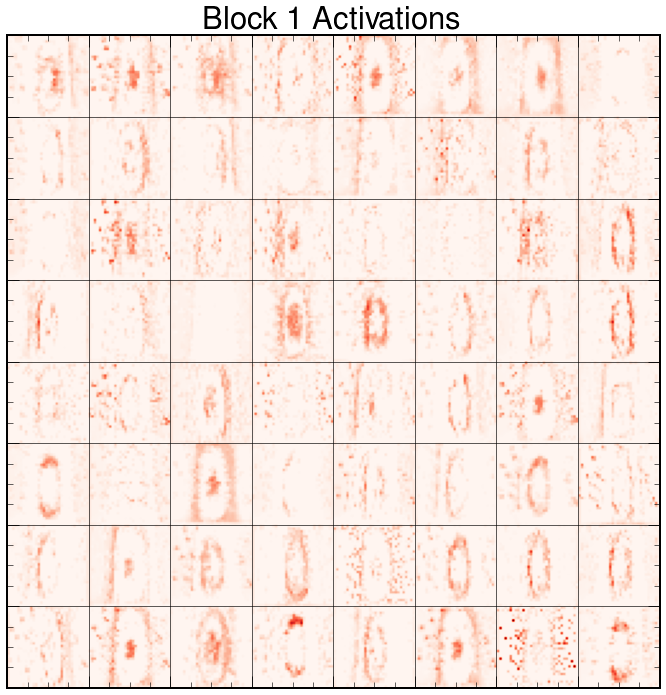

In [99]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], xticklabels=[''],
         yticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], yticklabels=[''])
extent = (0, 256, 256, 0)
axs.imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 1 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

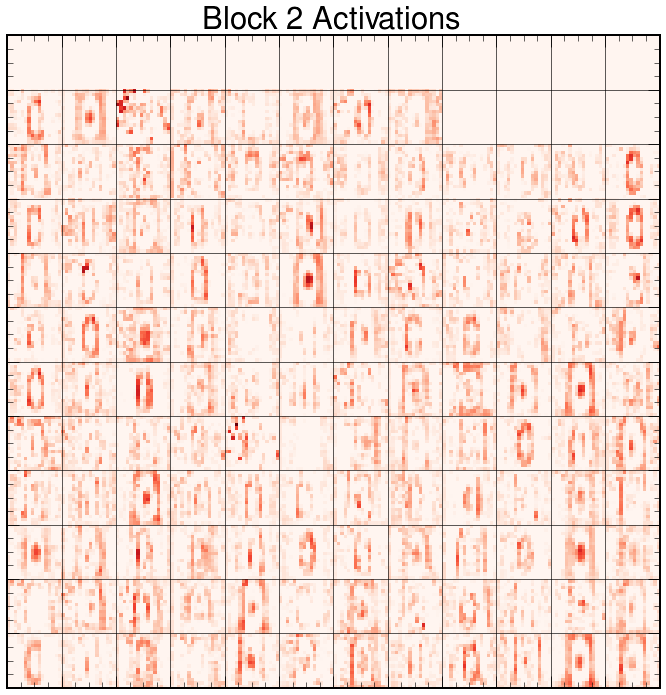

In [100]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], xticklabels=[''],
         yticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], yticklabels=[''])
extent = (0, 192, 192, 0)
axs.imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 2 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

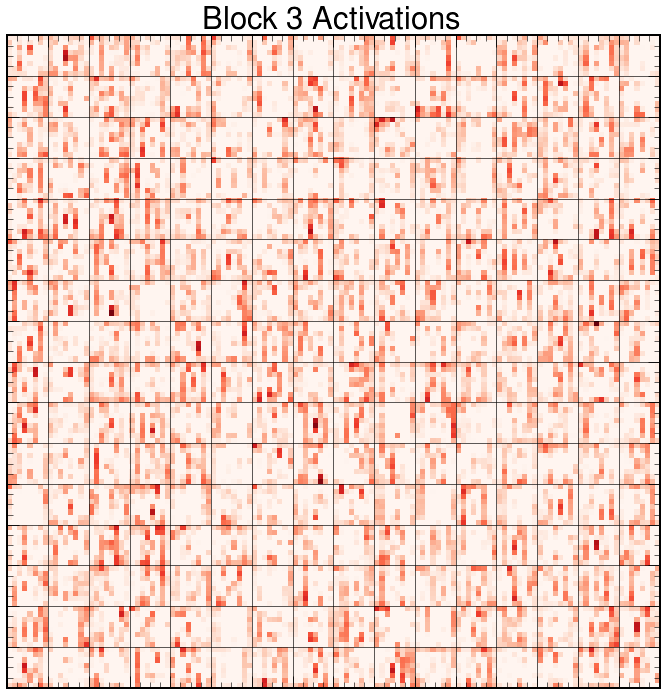

In [101]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
    xticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    yticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    xticklabels=[''], 
    yticklabels=[''])
extent = (0, 128, 128, 0)
axs.imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 3 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

In [ ]:
total_data = [len(events_b[events_b["prim_total"] == i]) for i in range(4)]
p_data = [len(events_b[events_b["prim_p"] == i]) for i in range(4)]
cp_data = [len(events_b[events_b["prim_cp"] == i]) for i in range(4)]
np_data = [len(events_b[events_b["prim_np"] == i]) for i in range(4)]
g_data = [len(events_b[events_b["prim_g"] == i]) for i in range(4)]
cats = np.arange(4)
width = 0.8

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats-(2*width/5), p_data, color="rebeccapurple", width=width/5)
axs.bar(cats-(width/5), cp_data, color="mediumslateblue", width=width/5)
axs.bar(cats, np_data, color="mediumblue", width=width/5)
axs.bar(cats+(width/5), g_data, color="midnightblue", width=width/5)
axs.bar(cats+(2*width/5), cats, color="royalblue", width=width/5)
axs.set_xticks(cats)
axs.set_xticklabels(("0", "1", "2", "2+"), fontsize=20)
axs.set_ylabel("Frequency")
axs.set_yscale('log')
plt.show()